# Building an NLP Pipeline

For the pair problem today, we'll build a pipeline which manages the *basic* requirements for an NLP project. The goal is to build a toolbox for converting one or more strings of text into a matrix (retaining textual information along the way).

## Step 1: Read in Data

In [94]:
from collections import OrderedDict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import re
import string

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

sns.set(context='notebook', style='whitegrid')

# sklearn
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [95]:
product_df = pd.read_csv('product_reviews_cleaned.csv')
product_df.shape
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66224 entries, 0 to 66223
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        66224 non-null  int64 
 1   reviews.rating    66224 non-null  int64 
 2   sentiment         66224 non-null  object
 3   reviews_keywords  66224 non-null  object
 4   reviewsConcat     66224 non-null  object
 5   name              66224 non-null  object
 6   reviews.title     66224 non-null  object
 7   categories        66224 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.0+ MB


In [96]:
product_df.head(3)

,Unnamed: 0,reviews.rating,sentiment,reviews_keywords,reviewsConcat,name,reviews.title,categories
0,0,5,positive,['just awesome i love this album it s very go...,Just Awesome i love this album. it's very good...,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1,1,5,positive,['good good flavor this was collected as par...,Good Good flavor. This was collected as part ...,Lundberg Organic Cinnamon Toast Rice Cakes,Good,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
2,2,5,positive,['good good flavor '],Good Good flavor.,Lundberg Organic Cinnamon Toast Rice Cakes,Good,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."


In [97]:
docs = product_df['reviews_keywords']

In [98]:
product_df['sentiment'].replace(['positive','negative'],[1,0],inplace=True)
product_df.head(3)

,Unnamed: 0,reviews.rating,sentiment,reviews_keywords,reviewsConcat,name,reviews.title,categories
0,0,5,1,['just awesome i love this album it s very go...,Just Awesome i love this album. it's very good...,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1,1,5,1,['good good flavor this was collected as par...,Good Good flavor. This was collected as part ...,Lundberg Organic Cinnamon Toast Rice Cakes,Good,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
2,2,5,1,['good good flavor '],Good Good flavor.,Lundberg Organic Cinnamon Toast Rice Cakes,Good,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."


In [99]:
X=product_df['reviews_keywords']
y=product_df['sentiment']

In [100]:
product_df['sentiment'].value_counts()

1    60735
0     5489
Name: sentiment, dtype: int64

## Stemming and Lemmatization

Stemming and Lemmatization are Text Normalization techniques. In Natural Language Processing, these are used to prepare text, words, and documents for further processing

In [101]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10, preprocessor=stemmer.stem)
dtm_tf = tf_vectorizer.fit_transform(docs)
print(dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs)
print(dtm_tfidf.shape)

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(66224, 5980)


C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1805: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


(66224, 5980)


In [102]:
X_train, X_test, y_train, y_test=train_test_split(dtm_tfidf,y,test_size=0.2, random_state=20)

## Principal Component Analysis - Dimensionality Reduction Technique

Dimensionality reduction methods are used for compressing a large number of features into a (much) smaller representation in a way that preserves as much information as possible for that choice of size

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = tfidf_vectorizer.fit_transform(product_df['reviews_keywords'])
X = pca.fit_transform(X.toarray())

In [104]:
X

array([[-0.02711391, -0.05579948],
       [-0.01111506, -0.0045747 ],
       [ 0.08839451, -0.11542746],
       ...,
       [-0.01774396, -0.09161225],
       [-0.06450916, -0.06821174],
       [-0.02938964, -0.09281792]])

In [105]:
k_means_cluster = KMeans(n_clusters=2, random_state=3)

cluster_labels = k_means_cluster.fit_predict(X)

In [106]:
def show_cluster_stats(cluster_labels, sentiment):
    
    print('Percentage of 1s in cluster 0: {}'
          .format(np.mean(sentiment[cluster_labels == 0])))
    
    print('Percentage of 1s in cluster 1: {}'
          .format(np.mean(sentiment[cluster_labels == 1])))
    
    sns.barplot(x=cluster_labels, y=sentiment)
    plt.title('Percentage sentiment label vs. cluster label')

Percentage of 1s in cluster 0: 0.89675766236326
Percentage of 1s in cluster 1: 0.9837949512557299


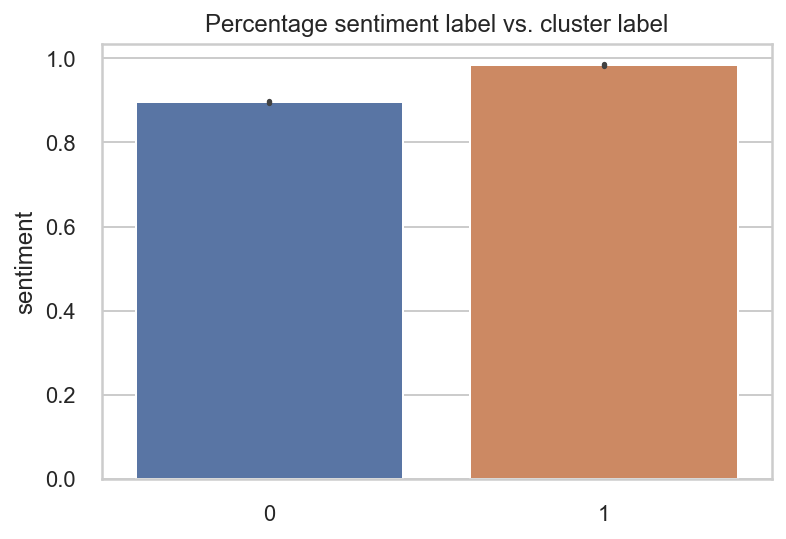

In [107]:
# extract just top 2 PCs
X_2_PCs = X[:,:2] 

k_means_cluster = KMeans(n_clusters=2, random_state=42)
cluster_labels = k_means_cluster.fit_predict(X_2_PCs)

show_cluster_stats(cluster_labels, y)

Text(0.5, 1.0, 'First Two Principal Components, With 2-Means Cluster Centers')

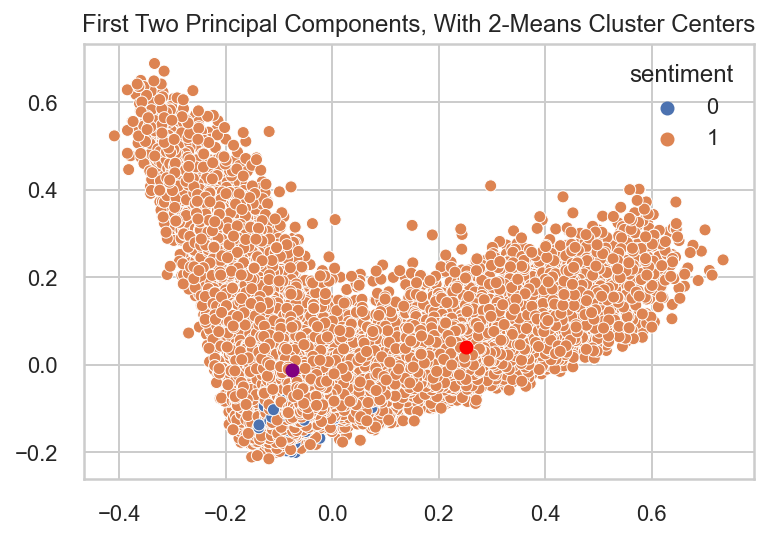

In [108]:
centers = k_means_cluster.cluster_centers_ 

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.scatter(centers[0,0], centers[0,1],color = 'purple') 
plt.scatter(centers[1,0], centers[1,1],color = 'red')
plt.title('First Two Principal Components, With 2-Means Cluster Centers')

In [109]:
product_df.loc[cluster_labels == 0, ['reviewsConcat','sentiment']].head(4)

,reviewsConcat,sentiment
0,Just Awesome i love this album. it's very good...,1
1,Good Good flavor. This was collected as part ...,1
2,Good Good flavor.,1
3,Disappointed I read through the s on here befo...,0


In [110]:
product_df.loc[cluster_labels == 1, ['reviewsConcat','sentiment']].head(4)

,reviewsConcat,sentiment
775,Betty Good,1
1078,Good Enjoyed it,1
1140,Really cute movie This is really cute to watch...,1
1141,it was good This movie was good.,1


## Classification Models to classify review sentiments - positive (1) and negative (0)

### LogisticRegression

In [111]:
from sklearn.linear_model import LogisticRegression

lr_model=LogisticRegression()
lr_model.fit(X_train,y_train)
print('Accuracy using LogisticRegression: ', lr_model.score(X_train, y_train))

Accuracy using LogisticRegression:  0.9689877121123464


### Random Forest Classifier

In [112]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train,y_train)
print('Accuracy using RandomForestClassifier: ', model.score(X_train, y_train))

Accuracy using RandomForestClassifier:  0.9999811245965382


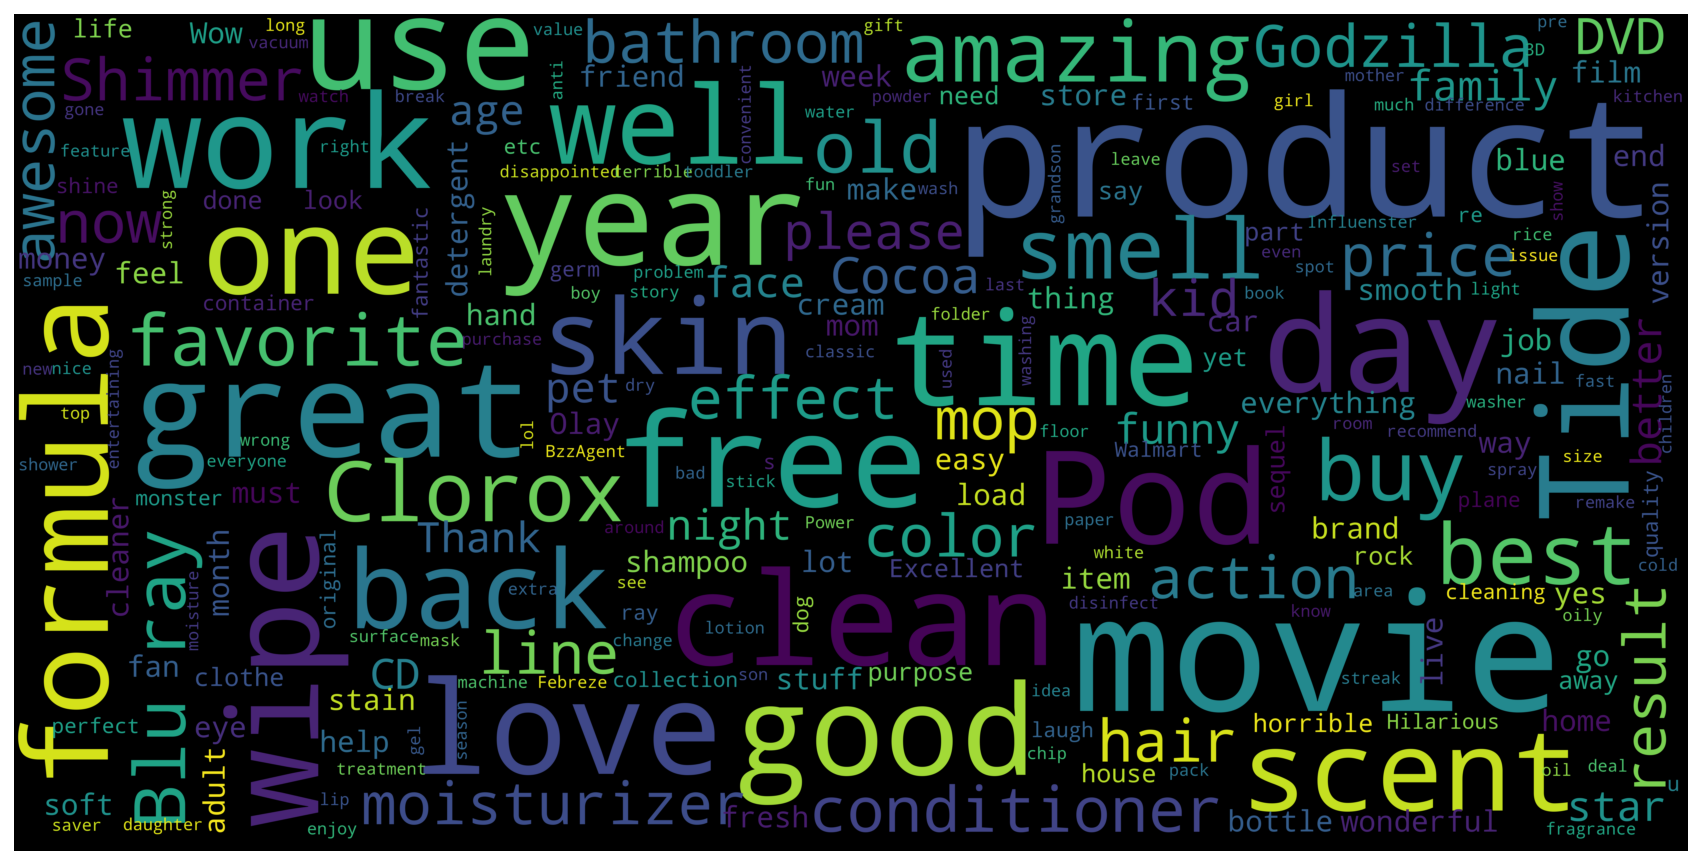

In [113]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in product_df['reviewsConcat'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='black', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

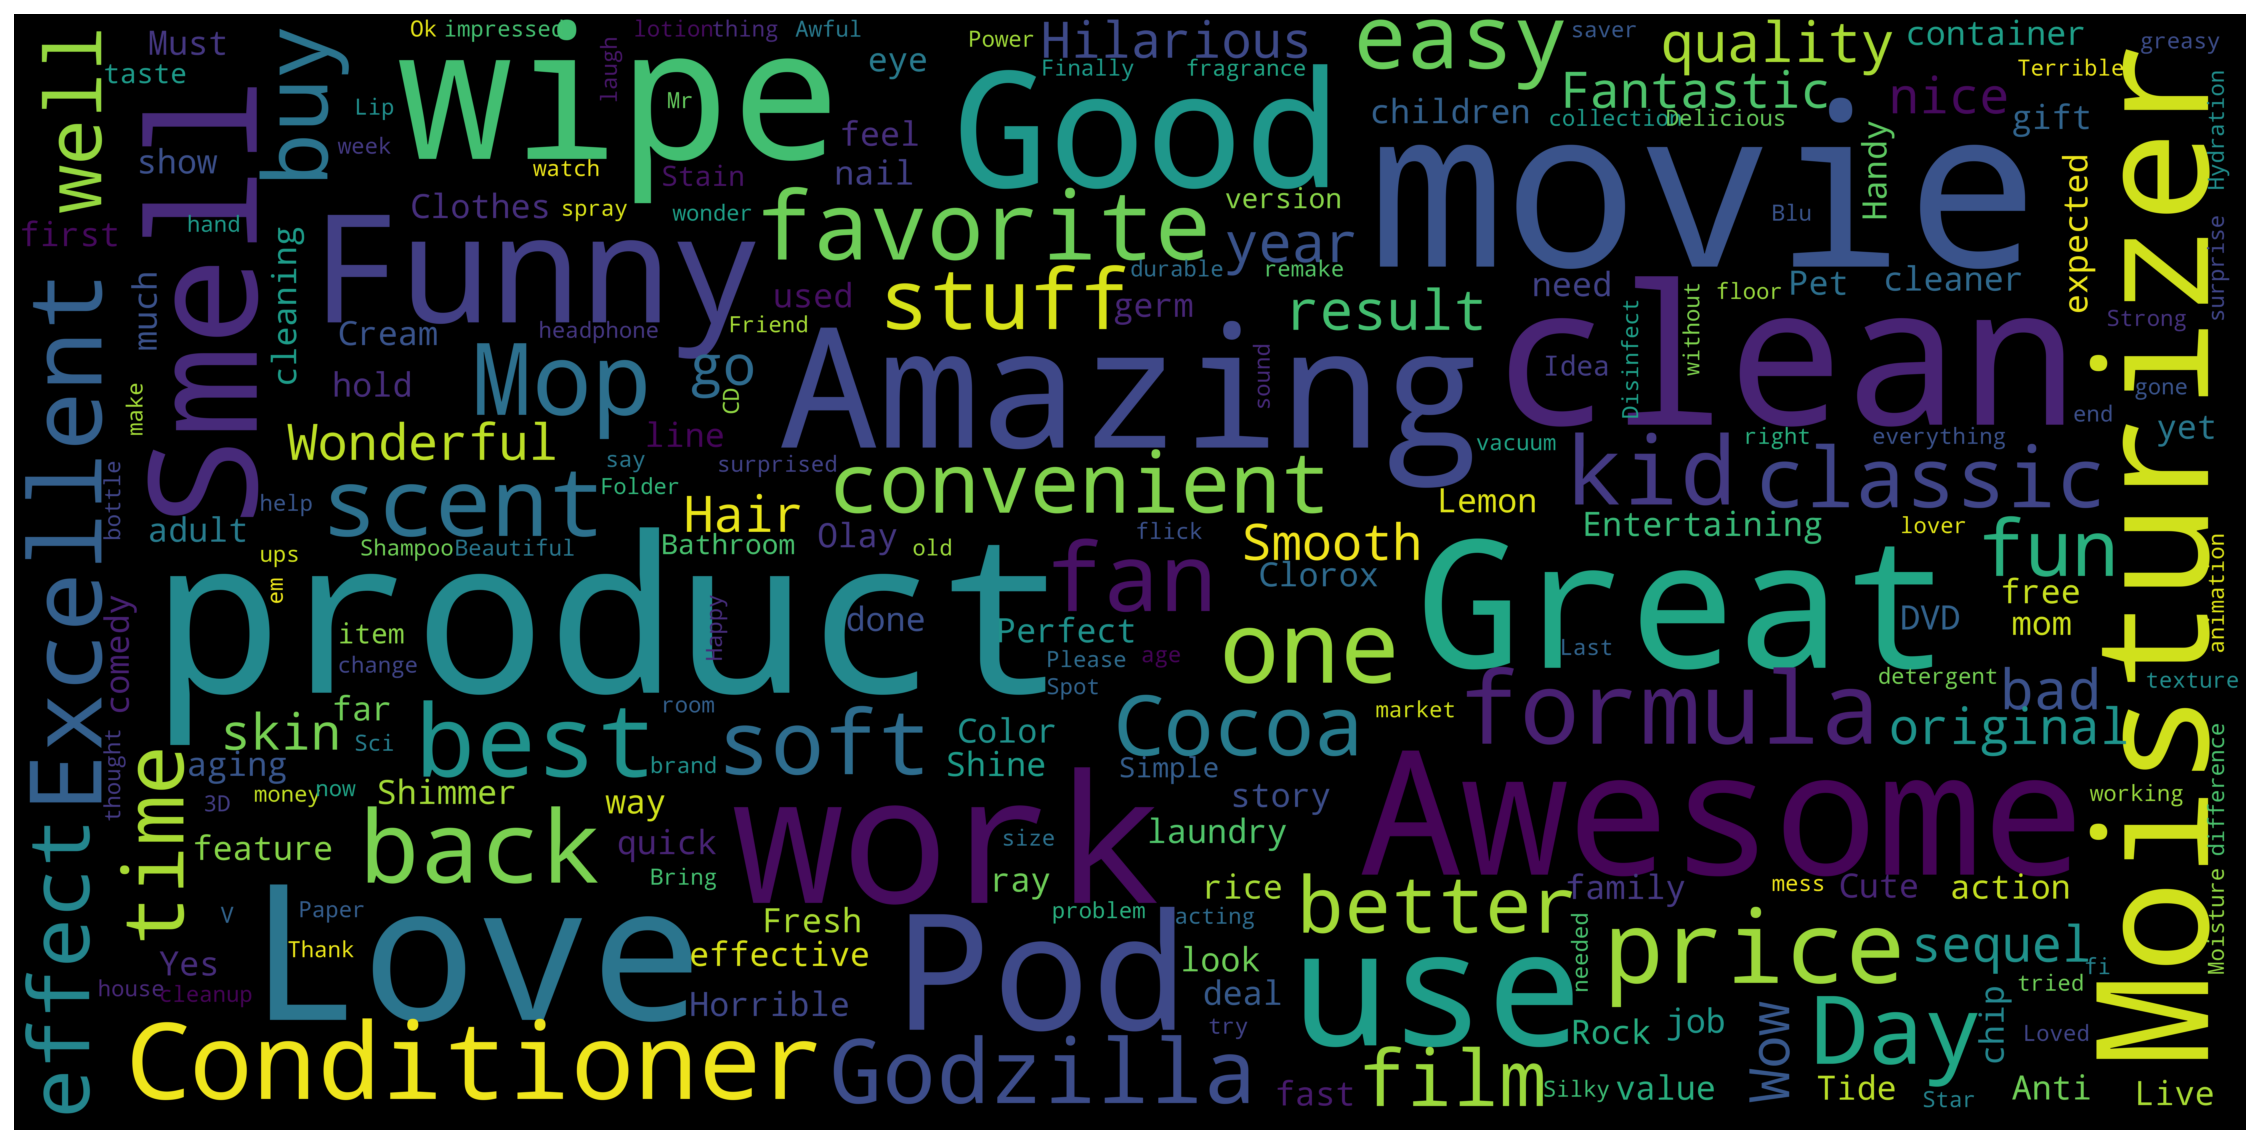

In [114]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in product_df['reviews.title'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(collocations = False, background_color='black', max_words=300, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Non-Negative Matrix Factorization (NMF) 

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

nmf = NMF(n_components=10)

nmf.fit(dtm_tfidf)

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=10)

In [116]:
doc_topic_matrix = nmf.transform(dtm_tfidf)
doc_topic_matrix

array([[0.00158528, 0.00050055, 0.00238714, ..., 0.02168294, 0.        ,
        0.        ],
       [0.        , 0.02517365, 0.00624149, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.0025524 , ..., 0.        , 0.        ,
        0.        ],
       [0.00029028, 0.00109896, 0.00946827, ..., 0.01147721, 0.        ,
        0.00050137],
       [0.00283609, 0.        , 0.00741311, ..., 0.00138313, 0.        ,
        0.00031605]])

## Document / Topic Matrix

In [117]:
doc_topic_matrix_df  = pd.DataFrame(doc_topic_matrix).add_prefix('topic_')
doc_topic_matrix_df[['reviewsConcat','reviews_keywords']] = product_df[['reviewsConcat','reviews_keywords']]
# doc_topic_matrix_df[['raw_reviews', 'clean_reviews']] = df[['text', 'clean_english']]
doc_topic_matrix_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,reviewsConcat,reviews_keywords
0,0.001585,0.000501,0.002387,0.021500,0.000263,0.006969,0.000000,0.021683,0.000000,0.000000,Just Awesome i love this album. it's very good...,['just awesome i love this album it s very go...
1,0.000000,0.025174,0.006241,0.114120,0.000000,0.000000,0.008564,0.000000,0.000000,0.000000,Good Good flavor. This was collected as part ...,['good good flavor this was collected as par...
2,0.000000,0.000000,0.000000,0.123852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Good Good flavor.,['good good flavor ']
3,0.000713,0.005805,0.006262,0.000554,0.000000,0.015396,0.000239,0.000000,0.000000,0.000000,Disappointed I read through the s on here befo...,['disappointed i read through the s on here be...
4,0.000960,0.000000,0.021502,0.000623,0.000000,0.002457,0.001347,0.000000,0.000107,0.000102,Irritation My husband bought this gel for us. ...,['irritation my husband bought this gel for us...
5,0.002828,0.000000,0.009633,0.001870,0.003553,0.007839,0.003706,0.023416,0.000032,0.000000,Not worth it My boyfriend and I bought this to...,['not worth it my boyfriend and i bought this ...
6,0.001917,0.000000,0.013120,0.002717,0.001577,0.013964,0.005422,0.001587,0.000599,0.000000,Disappointing Bought this earlier today and wa...,['disappointing bought this earlier today and ...
7,0.001763,0.000000,0.015374,0.000000,0.001879,0.011958,0.011073,0.001253,0.003604,0.000000,Not happy at all I bought this product for my ...,['not happy at all i bought this product for m...
8,0.000220,0.000000,0.011816,0.002617,0.006994,0.010416,0.004129,0.001170,0.001603,0.013630,Very disappointing My husband and I bought thi...,['very disappointing my husband and i bought t...
9,0.001738,0.000000,0.005925,0.003854,0.001442,0.015798,0.001293,0.002196,0.000489,0.000000,Don't buy Got as a surprise for my husband the...,['don t buy got as a surprise for my husband t...


In [118]:
doc_topic_matrix_df.shape

(66224, 12)

## Word/Topic Matrix

In [119]:
vocab = tfidf_vectorizer.get_feature_names()
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head(15)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
aaron,0.001120,0.000000,0.000002,0.000011,0.000000,0.000000,0.000000,0.001436,0.000000,0.000000
abilities,0.000437,0.001742,0.001061,0.001472,0.000169,0.001199,0.000000,0.000000,0.000000,0.000000
ability,0.000000,0.007710,0.005658,0.001643,0.004712,0.009625,0.000144,0.003784,0.000000,0.000000
able,0.012948,0.012329,0.056094,0.004394,0.007631,0.056805,0.058842,0.015171,0.002305,0.000000
abrasive,0.000000,0.000322,0.001256,0.000000,0.000923,0.000000,0.000385,0.003563,0.000000,0.000000
absolute,0.001942,0.004072,0.009929,0.000000,0.000000,0.005572,0.000740,0.009567,0.000000,0.000000
absolutely,0.064673,0.000000,0.056026,0.000000,0.000000,0.034548,0.094306,0.214872,0.020115,0.000000
absolutley,0.000000,0.001667,0.000000,0.001090,0.000000,0.000381,0.000554,0.003050,0.000000,0.000332
absolutly,0.000000,0.000327,0.000000,0.000000,0.000006,0.002569,0.001237,0.006081,0.000000,0.000000
absorb,0.000000,0.000000,0.020502,0.000000,0.000000,0.000000,0.001773,0.000000,0.000000,0.000000


In [120]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [121]:
# Fifteen topics.
docs = product_df['reviewsConcat']
preprocessor = None
vectorizer = TfidfVectorizer(stop_words="english")
topic_modeler = NMF(10, random_state=20, max_iter=1000)  # NOTE: I use a random state here to make the results deterministic.

make_topics(docs, preprocessor, vectorizer, topic_modeler);

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 MOVIE, ENJOYED, WATCH, LOVED, AWESOME, GODZILLA, CUTE, REALLY, WATCHING, ACTION, EXCELLENT, BEST, GREAT, WATCHED, RECOMMEND 

Topic 1:
 WIPES, CLOROX, COLLECTED, PROMOTION, USE, CLEAN, EASY, CLEANING, DISINFECTING, CONVENIENT, KITCHEN, HOUSE, BATHROOM, QUICK, PRODUCT 

Topic 2:
 SKIN, PRODUCT, MOISTURIZER, OLAY, FACE, COLLECTED, PROMOTION, USING, FEEL, TOTAL, EFFECTS, LIKE, FEELS, SMOOTH, AGING 

Topic 3:
 GOOD, ORIGINAL, PRICE, PRETTY, SEQUEL, ACTION, LIKE, STORY, QUALITY, REALLY, BETTER, LIKED, NICE, BUY, JUST 

Topic 4:
 GREAT, PRODUCT, PRICE, WORKS, BUY, SMELLS, RECOMMEND, MOVIES, QUALITY, USE, VALUE, CLEANING, JOB, STORY, DEAL 

Topic 5:
 TIDE, PODS, CLOTHES, CLEAN, LAUNDRY, SMELL, DETERGENT, USE, FRESH, EASY, SCENT, POD, JUST, PRODUCT, USED 

Topic 6:
 HAIR, CONDITIONER, SHAMPOO, SOFT, RECEIVED, PRODUCT, FREE, COLLECTED, PROMOTION, INFLUENSTER, TESTING, OILY, PURPOSES, OPINIONS, MASK 

Topic 7:
 LOVE, SMELL, PRODUCT, AWESOME, ABSOLUTELY, HOUSE, AMAZING, KIDS, JUST, MAKE

# Topic Interpretations
 
 
### TOPIC_0: Thriller Movie Review
 MOVIE, ENJOYED, WATCH, LOVED, AWESOME, GODZILLA, CUTE, REALLY, WATCHING, ACTION, EXCELLENT, BEST, GREAT, WATCHED, RECOMMEND 

### TOPIC_1:Cleaning Product Review
 WIPES, CLOROX, COLLECTED, PROMOTION, USE, CLEAN, EASY, CLEANING, DISINFECTING, CONVENIENT, KITCHEN, HOUSE, BATHROOM, QUICK, PRODUCT 

### TOPIC_2: Skin Product Review (Moisturizer)
 SKIN, PRODUCT, MOISTURIZER, OLAY, FACE, COLLECTED, PROMOTION, USING, FEEL, TOTAL, EFFECTS, LIKE, FEELS, SMOOTH, AGING 

### TOPIC_3: Movie Review
 GOOD, ORIGINAL, PRICE, PRETTY, SEQUEL, ACTION, LIKE, STORY, QUALITY, REALLY, BETTER, LIKED, NICE, BUY, JUST 

### TOPIC_4: Household Cleaning Supplies Review
 GREAT, PRODUCT, PRICE, WORKS, BUY, SMELLS, RECOMMEND, MOVIES, QUALITY, USE, VALUE, CLEANING, JOB, STORY, DEAL 

### TOPIC_5: Laundry Detergent Review
 TIDE, PODS, CLOTHES, CLEAN, LAUNDRY, SMELL, DETERGENT, USE, FRESH, EASY, SCENT, POD, JUST, PRODUCT, USED 

### TOPIC_6: Hair Product Review
 HAIR, CONDITIONER, SHAMPOO, SOFT, RECEIVED, PRODUCT, FREE, COLLECTED, PROMOTION, INFLUENSTER, TESTING, OILY, PURPOSES, OPINIONS, MASK 

### TOPIC_7: Food / Personal Care Product Review
 LOVE, SMELL, PRODUCT, AWESOME, ABSOLUTELY, HOUSE, AMAZING, KIDS, JUST, MAKES, PRODUCTS, SMELLS, LIP, COLOR, MOP 

### TOPIC_8: Comedy Movie Review
 KIDS, FUNNY, ADULTS, LOVED, CUTE, MOVIE, WATCH, ENTERTAINING, HILARIOUS, ADULT, FUN, PETS, HUMOR, REALLY, ENJOY 

### TOPIC_9: Kids/Family Movie Review
 FAMILY, FUN, WATCH, ENJOYED, NIGHT, ENTIRE, MOVIE, ENJOY, FILM, FRIENDS, CUTE, AGES, ENTERTAINING, PETS, FRIENDLY 

## Let's look at some reviews from each of these topics

In [122]:
# for review in product_df['reviewsConcat'].sample(10).values:
for review in doc_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(2)['reviewsConcat'].values:
    print(review)
    print()

Must have This was a must have movie since I have the first one.

movie love the movie



In [123]:
for review in doc_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(2)['reviewsConcat'].values:
    print(review)
    print()

Clorox Wipes Clorox wipes makes it so easy to clean. I use them everywhere. This  was collected as part of a promotion.

Clorox wipes Clorox disinfecting wipes are easy to use and convenient This  was collected as part of a promotion.



In [124]:
for review in doc_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(1)['reviewsConcat'].values:
    print(review)
    print()

A Great Skin Product! I think Olay Total Effects 7 in 1 Anti-Aging Moisturizer GotItForFree is a wonderful product. I tend to have problems with very dry skin that never seems to have a glow to it. After trying this skin product I have noticed an overall difference. My skin looks hydrated with a nice glow, the fine lines and wrinkles are less noticeable, as well as there is a more even skin tone. I'm not sure the last time my skin felt so soft. If you are looking for a skin care product that provides you with soft, radiant, smooth and even toned skin.....give this one a try. This  was collected as part of a promotion.



In [125]:
for review in doc_topic_matrix_df.sort_values(by='topic_5', ascending=False).head(2)['reviewsConcat'].values:
    print(review)
    print()

Tide pods are great to use. Tide pods are great for the clothes and easy to use.

Tide Pods With Febreeze I absolutely LOVE these tide pods! They make my clothes smell great for long time!! They clean my clothes so well! My whole laundry room smelled great while the clothes were running. I do feel like they are a bit pricey but I think it Is worth it! I used this Tide pods a couple of times now and I really liked it. The smell was pleasant and fresh. I didn't use it for clothes with hard stains yet, but I washed our regular laundry with this. It was so easy to use, just pop the pods with laundry and start the washer. It gave our clothes a clean and nice fresh scent. Overall, loved this product and I would definitely recommend anyone to try it. GOTITFORFREE TIDEPODS BZZAGENT This  was collected as part of a promotion.



In [126]:
for review in doc_topic_matrix_df.sort_values(by='topic_6', ascending=False).head(1)['reviewsConcat'].values:
    print(review)
    print()

Smooth, Happy Hair for Days! This conditioner is wonderful. Using it as part of the three-part system, my hair is left soft, smelling amazing, and feeling clean and light for days. As thick is my hair is, I am used to having conditioner way my hair down, or leave my hair too dry if not enough is used. This struck the perfect balance, leaving my hair so, so soft and beautiful. I received these products free/complimentary for testing purposes, but all opinions are my own. This  was collected as part of a promotion.



In [127]:
for review in doc_topic_matrix_df.sort_values(by='topic_8', ascending=False).head(2)['reviewsConcat'].values:
    print(review)
    print()

Funny for kids My kids and I loved this movie, funny and entertaining.

Very funny this is a very funny move for adults...NOT for kids



In [128]:
for review in doc_topic_matrix_df.sort_values(by='topic_5', ascending=False).head(2)['reviewsConcat'].values:
    print(review)
    print()

Tide pods are great to use. Tide pods are great for the clothes and easy to use.

Tide Pods With Febreeze I absolutely LOVE these tide pods! They make my clothes smell great for long time!! They clean my clothes so well! My whole laundry room smelled great while the clothes were running. I do feel like they are a bit pricey but I think it Is worth it! I used this Tide pods a couple of times now and I really liked it. The smell was pleasant and fresh. I didn't use it for clothes with hard stains yet, but I washed our regular laundry with this. It was so easy to use, just pop the pods with laundry and start the washer. It gave our clothes a clean and nice fresh scent. Overall, loved this product and I would definitely recommend anyone to try it. GOTITFORFREE TIDEPODS BZZAGENT This  was collected as part of a promotion.

